# Generalized Linear Models for Count Data (Lab 2)

### Intro and objectives


### In this lab you will learn:
1. examples of generalized linear models
2. how to fit these models in Python


## What I hope you'll get out of this lab
* The feeling that you'll "know where to start" when you need to fit generalized linear models
* Worked Examples
* How to interpret the results obtained

## Objectives of the Analysis
### We will analyze whether the Age of a person and the District they live in affect the number of insurance Claims they file

In [1]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

# Load the "Insurance in Sweden" dataset
insurance_data = sm.datasets.get_rdataset("Insurance", package="MASS").data



In [2]:
insurance_data.head()

,District,Group,Age,Holders,Claims
0,1,<1l,<25,197,38
1,1,<1l,25-29,264,35
2,1,<1l,30-35,246,20
3,1,<1l,>35,1680,156
4,1,1-1.5l,<25,284,63


In [3]:
insurance_data.groupby('Age').count()

,District,Group,Holders,Claims
Age,,,,
25-29,16,16,16,16
30-35,16,16,16,16
<25,16,16,16,16
>35,16,16,16,16


In [4]:
insurance_data.loc[insurance_data['Age']=='<25','Age']='1_<25'

insurance_data.loc[insurance_data['Age']=='30-35','Age']='3_30-35'

insurance_data.loc[insurance_data['Age']=='25-29','Age']='2_25-29'

insurance_data.loc[insurance_data['Age']=='>25','Age']='4_>25'

In [5]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   District  64 non-null     int64 
 1   Group     64 non-null     object
 2   Age       64 non-null     object
 3   Holders   64 non-null     int64 
 4   Claims    64 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 2.6+ KB


In [6]:
insurance_data.groupby('Age').count()

,District,Group,Holders,Claims
Age,,,,
1_<25,16,16,16,16
2_25-29,16,16,16,16
3_30-35,16,16,16,16
>35,16,16,16,16


In [7]:
insurance_data.describe()

,District,Holders,Claims
count,64.000000,64.000000,64.000000
mean,2.500000,364.984375,49.234375
std,1.126872,622.770601,71.162399
min,1.000000,3.000000,0.000000
25%,1.750000,46.750000,9.500000
50%,2.500000,136.000000,22.000000
75%,3.250000,327.500000,55.500000
max,4.000000,3582.000000,400.000000


### 1. Exploratory Data Analysis

<Axes: xlabel='Claims', ylabel='Count'>

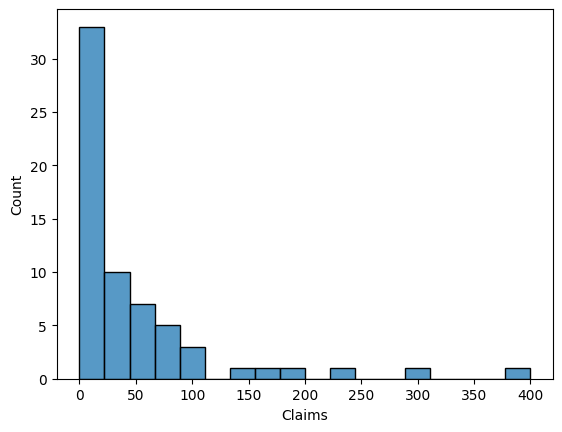

In [8]:
import seaborn as sns
sns.histplot(insurance_data,x='Claims')

In [9]:
insurance_data.columns

Index(['District', 'Group', 'Age', 'Holders', 'Claims'], dtype='object')

In [10]:
qualitativeFactorstoExplore=['District', 'Age']

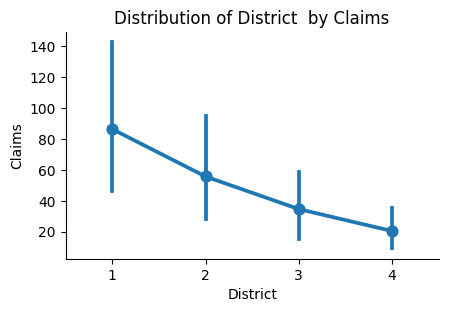

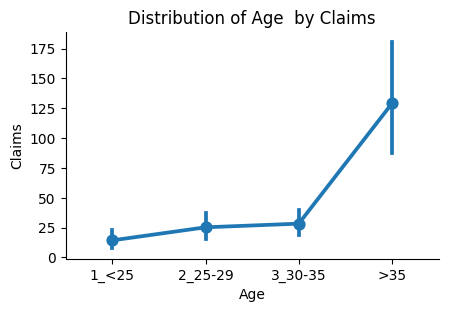

In [11]:
for factor in qualitativeFactorstoExplore:

  sns.catplot(data=insurance_data, x=factor, y="Claims", kind="point",height=3, aspect=1.5)
  #plt.yscale('log')
  plt.title(f'Distribution of {factor}  by Claims')
  plt.show()

<Axes: xlabel='District', ylabel='Holders'>

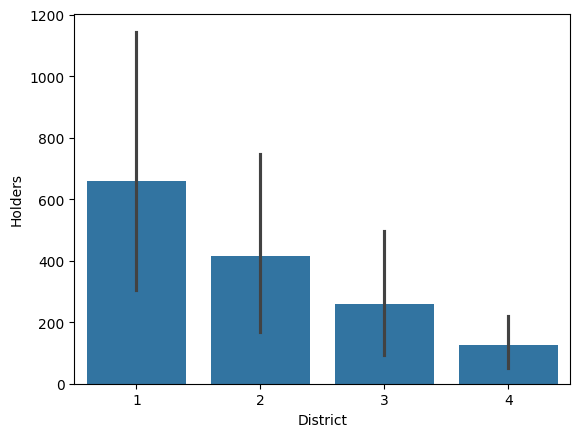

In [12]:
sns.barplot(data=insurance_data,x='District',y='Holders')

<Axes: xlabel='District', ylabel='Claims'>

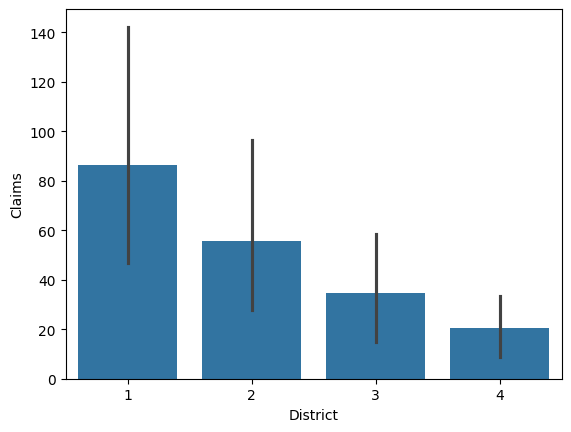

In [13]:
sns.barplot(data=insurance_data,x='District',y='Claims')

### Based on the previous figure we assume the factor: 'ClaimsHoldersRatio' to follow a Poisson distribution. We will use this as the response variable

## 2. Initial model

#### We will assume that the random variable approve follows a poisson distribution with parameter $\mu$
$Y_i\sim Poisson(\mu)$


#### We assume a log function, this means that we are assuming that the log odds of the mean can be modeled as a linear combination of the factors under consideration.

$ log(\mu)=\beta_0+\beta_1*x_1+\ldots+\beta_p*X_p $

In [14]:

import statsmodels.formula.api as smf
import numpy as np


# defining the poisson glm
poisson_glm = smf.glm(formula = 'Claims ~ Age + C(District)+Holders',
                      data = insurance_data,
                      family = sm.families.Poisson())

# fitting the model
results = poisson_glm.fit()

# Printing the summary of the regression results
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                   64
Model:                            GLM   Df Residuals:                       56
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -449.74
Date:                Mon, 07 Oct 2024   Deviance:                       582.16
Time:                        08:12:17   Pearson chi2:                     592.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.9381      0.072  

# 3. Model interpretation:


There are three coefficients for Age, the first factor level was omitted and is used as a referece level. Keeping that in mind we can interpret the results as follows. Compared to the first factor (young people less than 25):

People aged 25-29 and 30–35 file more insurance claims than their younger counterparts ($e^{0.53}=1.648$ and $e^{0.61}=1.84$  respectively). People older than 35 file way more claims than people younger than 25 ($e^{1.52}=4.57$).

Districs 2,3 and 4 file less claims than the reference group (Disctrict 1).

Higher number of holders lead to marginally higher number of claims.

###4. Analysis


#### In Count models it is important to check for overdispersion

In [15]:
# Calculating the dispersion statistic
# 1. Pearson chi-squared statistic
pearson_chi2 = np.sum((results.resid_pearson)**2)
# 2. Degrees of freedom
degrees_of_freedom = insurance_data.shape[0] - results.df_model - 1
# 3. Dispersion statistic (phi)
dispersion_stat = pearson_chi2 / degrees_of_freedom

print(f'Dispersion Statistic: {dispersion_stat}')

# Interpretation
if dispersion_stat > 1:
    print('Evidence of overdispersion.')
else:
    print('No significant overdispersion detected.')

Dispersion Statistic: 10.571287139282962
Evidence of overdispersion.


## 2. Negative Binomial model

#### We found evidence of overdispersion. In this situation we can use negative binomial models.

#### We will assume that the random variable approve follows a negative Binomial distribution with parameter $\mu$
$Y_i\sim Poisson(\mu)$


#### We assume a log function, this means that we are assuming that the log odds of the mean can be modeled as a linear combination of the factors under consideration.

$ log(\mu)=\beta_0+\beta_1*x_1+\ldots+\beta_p*X_p $

In [16]:
# defining the poisson glm
negBinomial_glm = smf.glm(formula = 'Claims ~ Age + C(District)+Holders',
                      data = insurance_data,
                      family = sm.families.NegativeBinomial())

# fitting the model
results2 = negBinomial_glm.fit()

# Printing the summary of the regression results
print(results2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Claims   No. Observations:                   64
Model:                            GLM   Df Residuals:                       56
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -277.44
Date:                Mon, 07 Oct 2024   Deviance:                       22.653
Time:                        08:12:17   Pearson chi2:                     18.5
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6813
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.9656      0.357  

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### the results of both models are similar, some of the coefficients are no longer statistically significant in the second model